# User Book Score Predictor


## ⚡Importing the model from drive


In [ ]:
from google.colab import drive

# Mount Google Drive.
drive.mount('/content/drive')

# Set up the file path in Google Drive
# You might want to change the path according to the location of the file
json_file_path = '/content/drive/MyDrive/Colab Notebooks'

## 🔌Installing packages and importing the dataset from Kaggle


In [ ]:
import os
!pip install optuna
!pip install kaggle
!pip install transformers
! mkdir ~/.kaggle
os.environ['KAGGLE_CONFIG_DIR'] = json_file_path
!kaggle datasets download -d mohamedbakhet/amazon-books-reviews
! unzip amazon-books-reviews.zip -d datasets

mkdir: cannot create directory ‘/root/.kaggle’: File exists
amazon-books-reviews.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  amazon-books-reviews.zip
replace datasets/Books_rating.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace datasets/books_data.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


## All imports for the code


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import os
import gc
from google.colab import files
import sklearn
from sklearn.model_selection import train_test_split
import math
import copy
from typing import Tuple
# pytorch
import torch
import torch.nn as nn
from torch import nn, Tensor
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer
import torch.utils.data
from torch.utils.data import dataset
import torch.nn as nn
import torchvision
from torch.nn.utils import prune

import torchtext
# the following imports depend on `torchtext` version
import torchtext.data as data
import torchtext.datasets as datasets
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

import random, time, json
from tqdm import tqdm

# optuna
import optuna
import torch.optim as optim

from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, BertModel, BertForSequenceClassification, BertTokenizer
from transformers import get_scheduler

## ⭐ Extracting the relevant columns from the dataset and splitting the data to training, validation ant test sets

In [ ]:
ratings_data = pd.read_csv('datasets/Books_rating.csv', delimiter=',', on_bad_lines='skip')[['review/text', 'review/score']]

# This is the default option for the post tuned model, since the first 100_000 are "used" samples
# For the pre-tuned model you are free to set the boundaries as you will
start = 100_000
end = 105_000

# Split the dataset into train, validation, and test sets
train_review, test_review = train_test_split(ratings_data[start:end], test_size=0.2, random_state=42)
train_review, val_review = train_test_split(train_review, test_size=0.2, random_state=42)

# Print the sizes of each set
print("Train set size:", len(train_review))
print("Validation set size:", len(val_review))
print("Test set size:", len(test_review))

Train set size: 3200
Validation set size: 800
Test set size: 1000


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## 📖 Loading the BERT pretrained model, defining output layer with 5 labels to represent the scores, loading dictionary from BERT

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels = 5, # number of unique labels for our multi-class classification problem
    output_attentions = False,
    output_hidden_states = False,
)
model.to(device)

# Set up the file path
# You might want to change the path according to the location of the file
file_path = '/content/drive/MyDrive/Colab Notebooks/trained-model.bin'
file_path_trained = '/content/drive/MyDrive/Colab Notebooks/trained-model-100k.bin'

# Load the trained model
model.load_state_dict(torch.load(file_path_trained))

model.eval()
model.requires_grad_(True)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

## 📙 Preprocessing the reviews using BERT tokenizer to encode the words, convert to tensor and padd all reviews to be of the same length

In [ ]:
class ReviewsDataset(Dataset):
    def __init__(self, df, max_length=512):
        self.df = df
        self.tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
        self.max_length = max_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # input=review, label=stars
        review = self.df.loc[idx, 'review/text']
        # labels are 0-indexed
        label = int(self.df.loc[idx, 'review/score']) - 1

        encoded = self.tokenizer(
            review,                      # Review to encode.
            add_special_tokens=True,
            max_length=self.max_length,  # Truncate all segments to max_length.
            padding='max_length',        # Pad all reviews with the [PAD] token to the max_length.
            return_attention_mask=True,  # Construct attention masks.
            truncation=True
        )

        input_ids = encoded['input_ids']
        attn_mask = encoded['attention_mask']

        return {
            'input_ids': torch.tensor(input_ids),
            'attn_mask': torch.tensor(attn_mask),
            'label': torch.tensor(label)
        }

## 📔 Getting score prediction using the trained model. The function recieves string as an input, sends it to the model, and returns the prediction the model gives the book.

In [ ]:
#@title Prediction

def get_single_prediction(comment, model):
  """
  Predict a star rating from a review comment.

  :comment: the string containing the review comment.
  :model: the model to be used for the prediction.
  """

  df = pd.DataFrame()
  df['review/text'] = [comment]
  df['review/score'] = ['0']

  dataset = ReviewsDataset(df)

  TEST_BATCH_SIZE = 1
  NUM_WORKERS = 1

  test_params = {'batch_size': TEST_BATCH_SIZE,
              'shuffle': True,
              'num_workers': NUM_WORKERS}

  data_loader = DataLoader(dataset, **test_params)

  total_examples = len(df)
  predictions = np.zeros([total_examples], dtype=object)

  for batch, data in enumerate(data_loader):

    # Get the tokenization values.
    input_ids = data['input_ids'].to(device)
    mask = data['attn_mask'].to(device)

    # Make the prediction with the trained model.
    outputs = model(input_ids, mask)

    # Get the score rating.
    big_val, big_idx = torch.max(outputs[0].data, dim=1)
    star_predictions = (big_idx + 1).cpu().numpy()

  return star_predictions[0]


# Get the score predictions.
prediction = get_single_prediction("good book really", model)

print("model:", prediction)

model: 5


## 🧠 Defining the model's parameters

In [ ]:
MAX_LEN = 256
TEST_SIZE = 0.2
VAL_SIZE = 0.125
TRAIN_BATCH_SIZE = 32
TEST_BATCH_SIZE = 32
PRUNE_PERCENTAGE = 8.0944

CHECKPOINT_FILE = 'checkpoint.dat'
CHECKPOINT_FOLDER = 'Checkpoints'
EPOCHS = 25
LEARNING_RATE = 2e-5
PROJECT_FOLDER = '/content/drive/My Drive/Colab Notebooks'
MODEL_FOLDER = 'Model_V3'
SAVE_EVERY = 50
NUM_WORKERS = 2

## 🤯 Getting dataloaders to train the model

In [ ]:
train_review = train_review.reset_index(drop=True)
val_review = val_review.reset_index(drop=True)
test_review = test_review.reset_index(drop=True)

train_set = ReviewsDataset(train_review, MAX_LEN)
val_set = ReviewsDataset(val_review, MAX_LEN)
test_set = ReviewsDataset(test_review, MAX_LEN)

print("# of samples in train set: {}".format(len(train_set)))
print("# of samples in val set: {}".format(len(val_set)))
print("# of samples in test set: {}".format(len(test_set)))

train_params = {
                'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': NUM_WORKERS
                }
val_params = train_params

test_params = {
                'batch_size': TEST_BATCH_SIZE,
                'shuffle': False,
                'num_workers': NUM_WORKERS
              }

train_loader = DataLoader(train_set, **train_params)
val_loader = DataLoader(val_set, **val_params)
test_loader = DataLoader(test_set, **test_params)

# of samples in train set: 3200
# of samples in val set: 800
# of samples in test set: 1000


## 😠 Penalizing high error weights if they are not commonly used

In [ ]:
# For weighted Cross Entropy Loss
# Penalize errors higher if they come from a class with lower frequency

df = ratings_data[0:10_000]
score_groups = df.groupby('review/score')
score_distribution = []

for i in range(len(df['review/score'].unique())):
    score_distribution.append(len(score_groups.groups[i+1])/len(df))

score_distribution = torch.tensor(score_distribution, dtype=torch.float32)

weights = 1.0 / score_distribution
weights = weights / weights.sum()

In [ ]:
# Define the optimizer and scheduler
loss_function = torch.nn.CrossEntropyLoss(weight=weights.to(device), reduction='mean')
optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)
num_training_steps = EPOCHS * len(train_loader)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

In [ ]:
# Define the accuracy function
def calculate_accuracy(big_idx, targets):
    n_correct = (big_idx==targets).sum().item()
    return n_correct

## 👍 Defining the evaluation function. It gets as input the validation data loader and returns the validation accuracy and loss.

In [ ]:
# For validation
def validate(model, data_loader):
    model.eval()
    n_correct = 0
    nb_test_steps = 0
    nb_test_examples = 0
    test_loss = 0
    y_pred = []
    y_true = []

    with torch.no_grad():
        for _, data in enumerate(data_loader, 0):
            input_ids = data['input_ids'].to(device)
            mask = data['attn_mask'].to(device)
            labels = data['label'].to(device)

            outputs = model(input_ids, mask)
            loss = loss_function(outputs[0], labels)
            test_loss += loss.item()

            # gets labels with highest probabilities and their corresponding indices
            big_val, big_idx = torch.max(outputs[0].data, dim=1)
            n_correct += calculate_accuracy(big_idx, labels)

            preds = (big_idx + 1).cpu().tolist()
            gold = (labels + 1).cpu().tolist()
            y_pred.extend(preds)
            y_true.extend(gold)

            nb_test_steps += 1
            nb_test_examples += labels.size(0)

    epoch_loss = test_loss/nb_test_steps
    epoch_accu = (n_correct*100)/nb_test_examples
    print(f"Validation Loss: {epoch_loss}")
    print(f"Validation Accuracy: {epoch_accu}\n")

    return epoch_loss, epoch_accu

In [ ]:
# Define the scheduler callback function
def scheduler_callback(optimizer, epoch, scheduler):
    scheduler.step()
    return optimizer.param_groups[0]['lr']

## 🚆 The train function for the model.

In [ ]:
def train(epoch, prune_percentage, parameters_to_prune, optimizer, scheduler):

    # number of batches run by model
    nb_tr_steps = 0
    # number of training examples run by model
    nb_tr_examples = 0
    # number of examples classified correctly by model
    n_correct = 0
    tr_loss = 0

    model.train()

    for batch, data in enumerate(train_loader):

        input_ids = data['input_ids'].to(device)
        mask = data['attn_mask'].to(device)
        labels = data['label'].to(device)

        with torch.set_grad_enabled (True) and torch.cuda.amp.autocast(enabled=use_amp):

          outputs = model(input_ids, mask)
          loss = loss_function(outputs[0], labels)

        tr_loss += loss.item()

        # gets labels with highest probabilities and their corresponding indices
        big_val, big_idx = torch.max(outputs[0].data, dim=1)
        n_correct += calculate_accuracy(big_idx, labels)

        nb_tr_steps += 1
        nb_tr_examples+=labels.size(0)

        if batch % SAVE_EVERY == 0:
            loss_step = tr_loss/nb_tr_steps
            accu_step = (n_correct*100)/nb_tr_examples
            print("Batch {} of epoch {} complete.".format(batch, epoch+1))
            print(f"Training Loss: {loss_step}   Training Accuracy: {accu_step}")

            if not os.path.exists(CHECKPOINT_FOLDER):
              os.makedirs(CHECKPOINT_FOLDER)

            torch.save(model.state_dict(), os.path.join(PROJECT_FOLDER, CHECKPOINT_FOLDER, CHECKPOINT_FILE))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    #print('\n*****\n')
    # print(f'The Total Accuracy for Epoch {epoch+1}: {(n_correct*100)/nb_tr_examples}')
    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    print(f"Training Loss: {epoch_loss}")
    print(f"Training Accuracy: {epoch_accu}\n")

    # Evaluate model after training it on this epoch
    val_loss, val_accu = validate(model, val_loader)

    # Update the learning rate using the scheduler callback
    lr = scheduler_callback(optimizer, epoch, scheduler)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    # Remove pruning from the model after each epoch
    for module, parameter_name in parameters_to_prune:
        prune.remove(module, parameter_name)

    torch.save(model.state_dict(), os.path.join(PROJECT_FOLDER, CHECKPOINT_FOLDER, CHECKPOINT_FILE))

    return epoch_loss, val_loss, epoch_accu, val_accu

## 🎆 Training loop
Saves the model that gives the best validation accuracy using deep copy method.

In [ ]:
train_loss_history = []
val_loss_history = []
train_acc_history = []
val_acc_history = []
use_amp = True

best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0
prune_percentage = PRUNE_PERCENTAGE

for epoch in range(EPOCHS):

    # Prune the model before training
    parameters_to_prune = []
    for name, module in model.named_modules():
        if isinstance(module, torch.nn.Linear):
            parameters_to_prune.append((module, "weight"))
            parameters_to_prune.append((module, "bias"))

    # Apply pruning to specified parameters
    for module, parameter_name in parameters_to_prune:
        prune.l1_unstructured(module, name=parameter_name, amount=prune_percentage / 100)

    # torch.cuda.empty_cache()
    train_loss, val_loss, train_acc, val_acc = train(epoch, prune_percentage, parameters_to_prune, optimizer, lr_scheduler)

    train_acc_history.append(train_acc)
    val_acc_history.append(val_acc)
    train_loss_history.append(train_loss)
    val_loss_history.append(val_loss)

    if val_acc > best_acc:

        best_acc = val_acc
        best_model_wts = copy.deepcopy(model.state_dict())

    # model.load_state_dict(best_model_wts)

    #lr_scheduler.step()


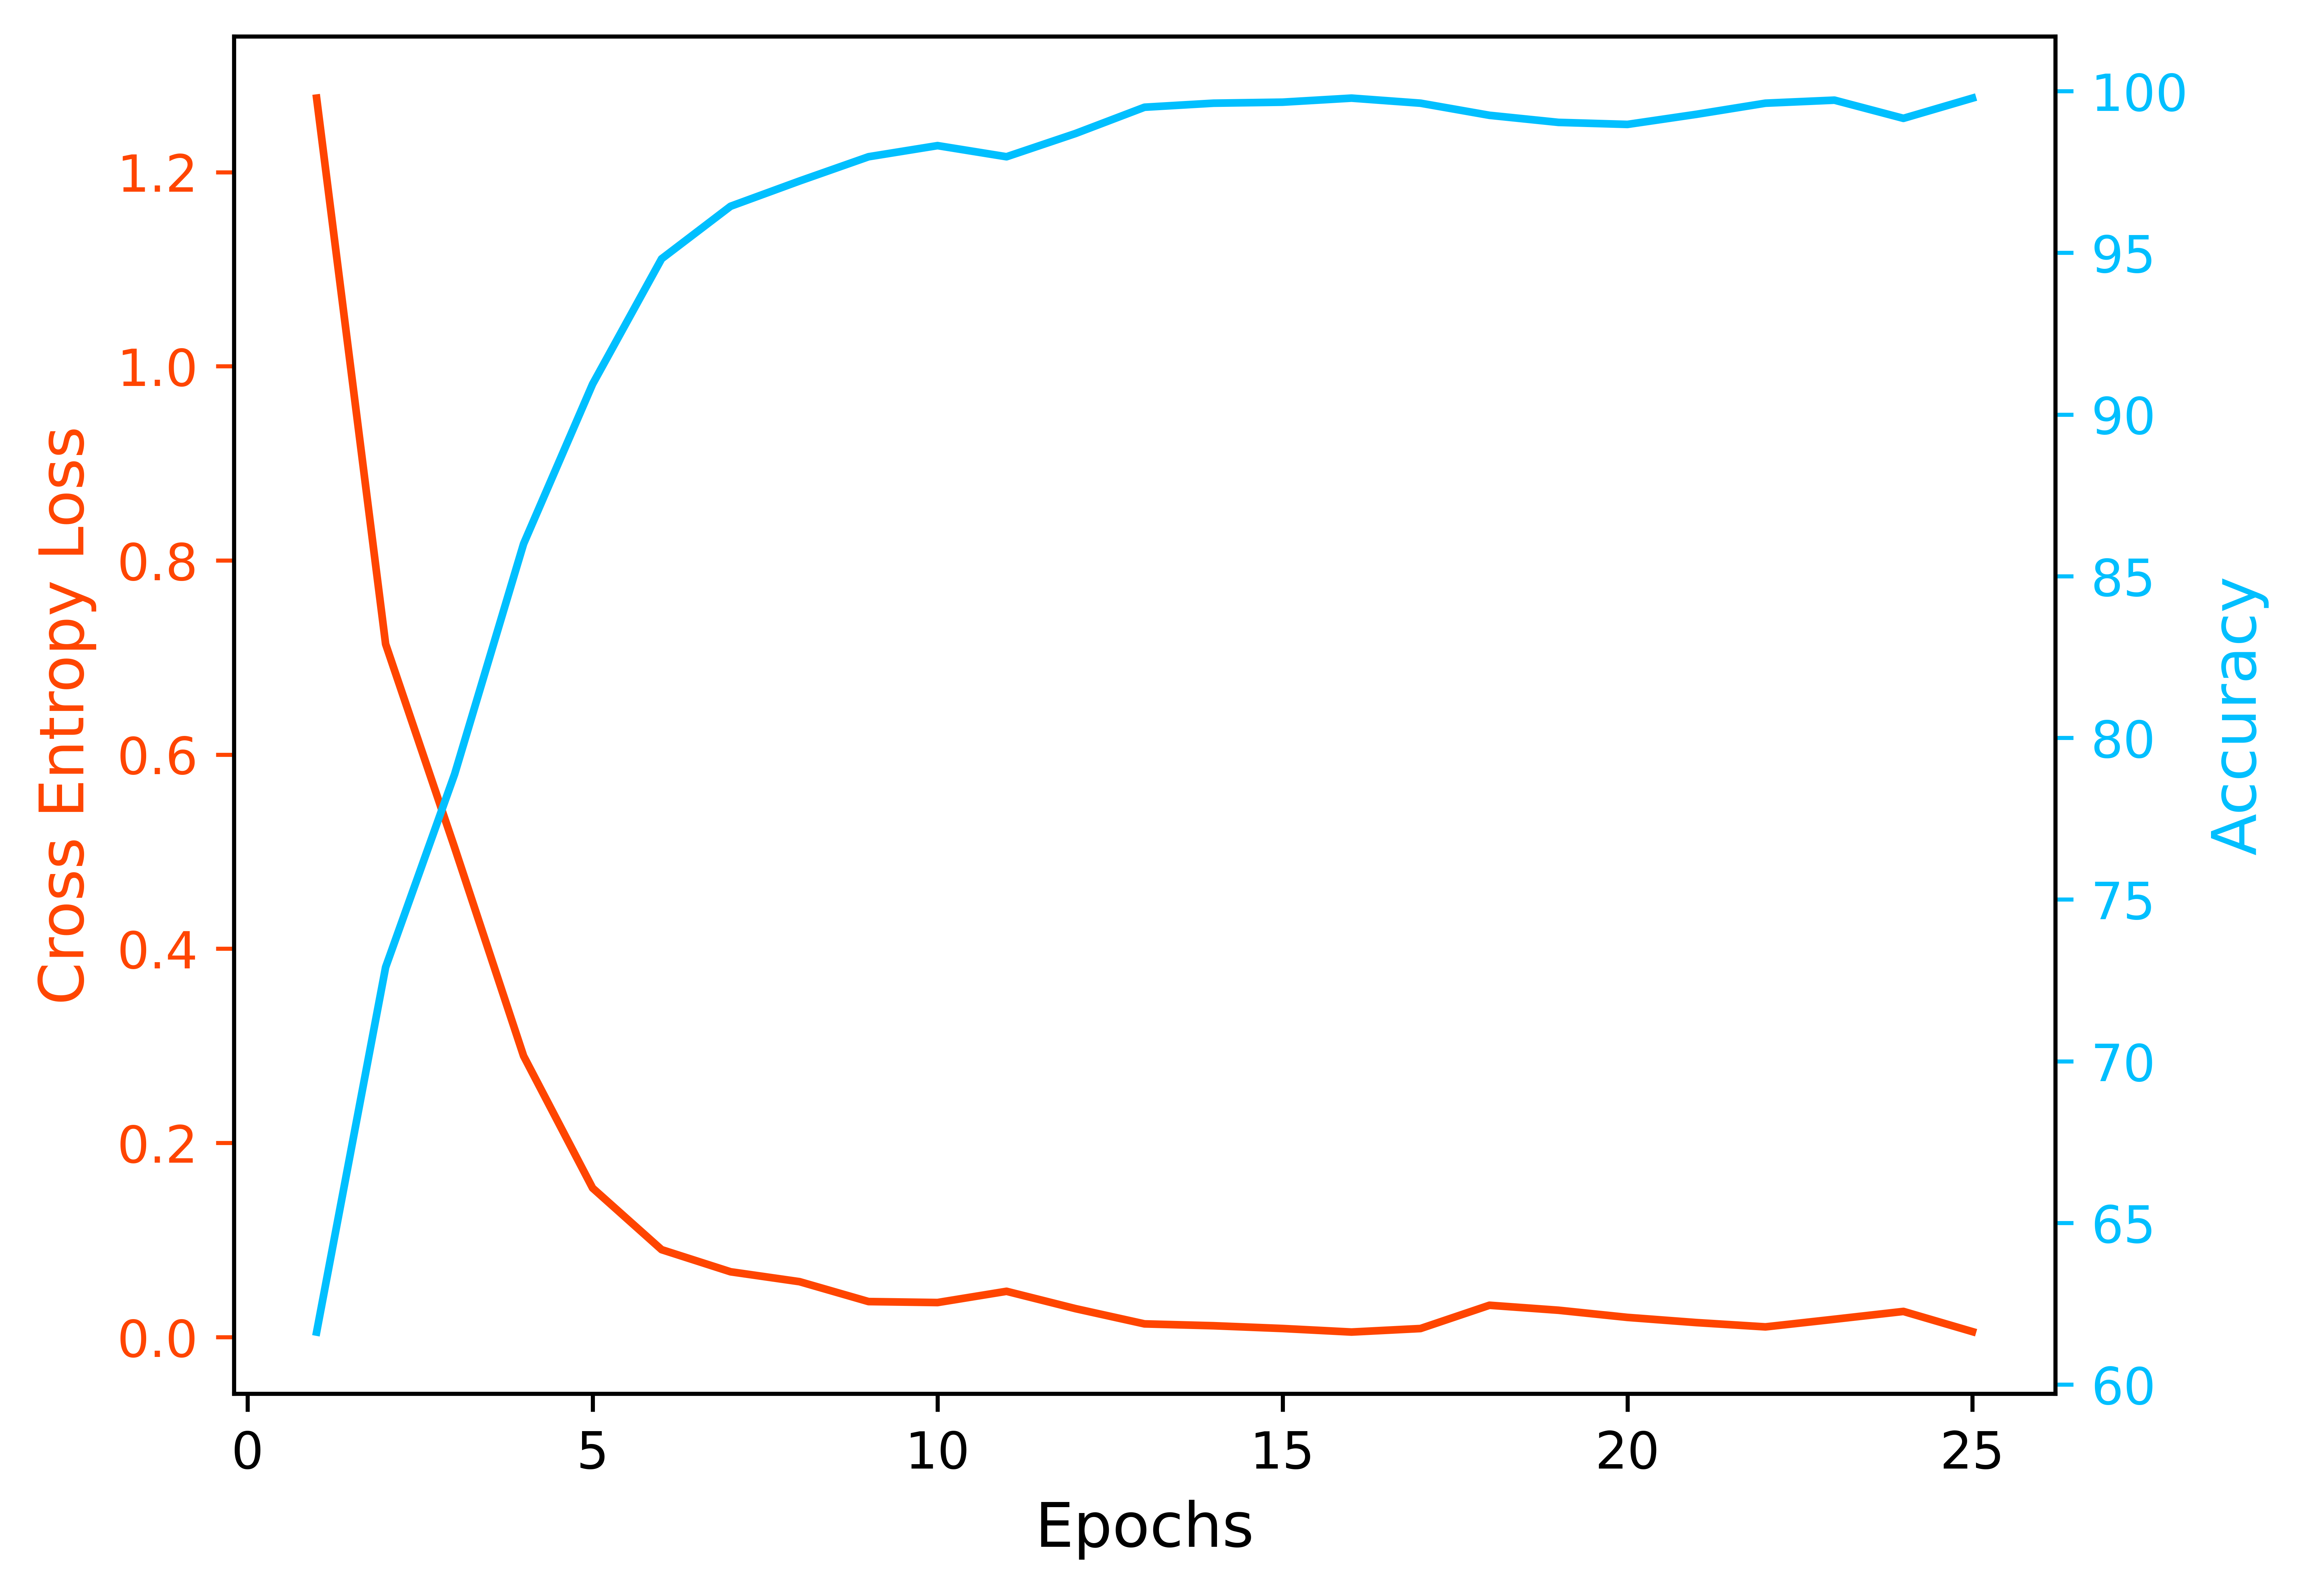

In [ ]:
fig,ax = plt.subplots(dpi=500)

ax.plot(range(1, EPOCHS + 1), train_loss_history, color="orangered")
ax.set_xlabel("Epochs", fontsize = 12)
ax.set_ylabel("Cross Entropy Loss", color="orangered", fontsize=12)
ax.tick_params(axis='y', colors='orangered')

ax2 = ax.twinx()
ax2.plot(range(1, EPOCHS + 1), train_acc_history, color="deepskyblue")
ax2.set_ylabel("Accuracy", color="deepskyblue", fontsize=12)
ax2.tick_params(axis='y', colors='deepskyblue')

plt.show()

## 📝 Test score

In [ ]:
# Test score
epoch_loss, epoch_acc = validate(model, test_loader)
print(epoch_loss)
print(epoch_acc)

## 🌃 The objective function that is given to Optuna. Reports the results to Optuna.

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

use_amp = True
# scaler = torch.cuda.amp.GradScaler(enabled=use_amp) # notice the `enabled` parameter

def objective(trial):

    # Generate the optimizers.
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)  # log=True, will use log scale to interplolate between lr
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)    # alternative version
    # optimizer = trial.suggest_categorical("optimizer", [optim.Adam, optim.RMSprop, optim.SGD])
    prune_percentage = trial.suggest_float("prune_percentage", 0.0, 50.0)

    num_training_steps = EPOCHS * len(train_loader)
    lr_scheduler = get_scheduler(
        name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
    )


    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(1):

      model.train()

      # Prune the model before training
      parameters_to_prune = []
      for name, module in model.named_modules():
          if isinstance(module, torch.nn.Linear):
              parameters_to_prune.append((module, "weight"))
              parameters_to_prune.append((module, "bias"))

      # Apply pruning to specified parameters
      for module, parameter_name in parameters_to_prune:
          prune.l1_unstructured(module, name=parameter_name, amount=prune_percentage / 100)


      train_loss, val_loss, train_acc, val_acc = train(epoch, prune_percentage, parameters_to_prune, optimizer, lr_scheduler)

      if val_acc > best_acc:

        best_acc = val_acc
        best_model_wts = copy.deepcopy(model.state_dict())

      model.load_state_dict(best_model_wts)

      lr_scheduler.step()

      trial.report(val_acc, epoch)
      if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return val_acc

In [ ]:
torch.cuda.empty_cache()

## 🍥 Creating Optuna experiments to choose the best hyper parameters.

In [ ]:
# now we can run the experiment
sampler = optuna.samplers.TPESampler()
study = optuna.create_study(study_name="exp_name", direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=100, timeout=3600)

pruned_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED]
complete_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

## Printing Optuna results

In [ ]:
optuna.visualization.plot_param_importances(study)

## 💾 Saving model checkpoint

In [ ]:
# You might want to change the path according to the location of the file

# file_path_trained = '/content/drive/MyDrive/Colab Notebooks/trained-model-better.bin'
# torch.save(model.state_dict(), '/content/drive/MyDrive/Colab Notebooks/trained-model-100k.bin')